In [162]:
import torch
import torch.nn as nn
import numpy as np
from torch import tensor,  sin, pi
import matplotlib.pyplot as plt
import pandas as pd

## PINNs for solving PDEs

Physics Informed Neural Networks (PINNS) are neural networks that incorporate physics, often described by a PDE, into the training process. This allows the network to be more robust and generalizable by not only learning from the data but also adhering to the underlying physics describing the data. Here, the approach begins with a 1D example problem and is then generalized to solve eigenvalue problems in higher dimensions.

The idea here is to use neural networks to approximate the solution $u$ to this PDE, leveraging their well-known ability as universal function approximators and also automatic differentiation to differentiate the output with respect to their input coordinates.

## 1D problem

Consider the following reaction-diffusion equation in 1D
$$
\begin{align*}
    -\Delta u + u &= (\pi^2+1)\sin(\pi x),\hspace{10pt}\text{ in }(0,1)\\
    u(0)&=u(1)=0
\end{align*}
$$

This PDE can be solved analytically and the exact solution is given by $u(x) = \sin(\pi x)$.

In [33]:
# RHS
def f(x):
    return (pi**2+1)*sin(pi*x)

# Exact Solution
def u_exact(x):
    return sin(pi*x)

### Creating neural network

In [87]:
# building PINN neural network using nn.Module class
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),           # here 1 describes that we are working in 1D
            nn.Tanh(),
            nn.Linear(64, 32),
            nn.Tanh(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

In [88]:
# incorporating automatic differentiation
def grad(outputs, inputs):
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs),create_graph=True)[0]

### Loss function

The key idea of PINNs is to incorporate the PDE directly into the loss function along with the boundary conditions. This can be thought of as penalizing the network prediction wherever it deviates from the governing PDE and boundary conditions. The gradients arising in the PDE can be easily computed using automatic differentiation. 

The parameters of the neural networks can be learned by minimizing the mean-squared error loss function
$$
\begin{align*}
    MSE = MSE_u + MSE_f
\end{align*}
$$
where
$$
\begin{align*}
    MSE_b = |u(0)|^2 + |u(1)|^2
\end{align*}
$$
and
$$
\begin{align*}
    MSE_i = \sum_{k=1}^{N_i} |-\Delta u(x_k) +u(x_k) - f(x_k)|^2
\end{align*}
$$
$N_i$ describes the number of collocation points which act as checkpoints to check whether the network prediction $u$ satisfies the PDE. $MSE_i$ describes the interior loss of network prediction, and $MSE_b$ describes the boundary loss. The collocation points, along with the endpoints, serve as training data for PINNs.

In [89]:
def compute_loss(model: nn.Module, x_train: torch.Tensor):
    # evaluating u(x), f(x), du/dx, d^2u/dx^2 at training data points
    x_train.requires_grad_(True)
    u = model(x_train)                      # model prediction on training data
    du = grad(u,x_train)
    d2u = grad(du,x_train)

    #ODE residual: -u"(x)+ u(x) - f(x)
    residual = -d2u[1:-1] + u[1:-1] - f(x_train[1:-1])     # ODE-based interior residual
    interior_loss = torch.mean(residual ** 2)              # mean-squared interior loss

    #calculating boundary loss for problem
    left_residual = model(x_train[0])
    right_residual = model(x_train[-1])
    boundary_loss = torch.mean(left_residual ** 2 + right_residual ** 2)    # mean-squared boundary loss

    return interior_loss + boundary_loss

### Generating Training and test dataset

The training set cnosists of uniformly spaced points in the inNote that, here the size of training set is $N_i+2$.

In [96]:
# generate the training set
n_train = 11
x_train = torch.linspace(0,1,n_train).reshape(-1,1)
x_train

tensor([[0.0000],
        [0.1000],
        [0.2000],
        [0.3000],
        [0.4000],
        [0.5000],
        [0.6000],
        [0.7000],
        [0.8000],
        [0.9000],
        [1.0000]])

In [97]:
# generate the test set
n_test = 100
x_test = torch.linspace(0,1,n_test).reshape(-1,1)
x_test 

tensor([[0.0000],
        [0.0101],
        [0.0202],
        [0.0303],
        [0.0404],
        [0.0505],
        [0.0606],
        [0.0707],
        [0.0808],
        [0.0909],
        [0.1010],
        [0.1111],
        [0.1212],
        [0.1313],
        [0.1414],
        [0.1515],
        [0.1616],
        [0.1717],
        [0.1818],
        [0.1919],
        [0.2020],
        [0.2121],
        [0.2222],
        [0.2323],
        [0.2424],
        [0.2525],
        [0.2626],
        [0.2727],
        [0.2828],
        [0.2929],
        [0.3030],
        [0.3131],
        [0.3232],
        [0.3333],
        [0.3434],
        [0.3535],
        [0.3636],
        [0.3737],
        [0.3838],
        [0.3939],
        [0.4040],
        [0.4141],
        [0.4242],
        [0.4343],
        [0.4444],
        [0.4545],
        [0.4646],
        [0.4747],
        [0.4848],
        [0.4949],
        [0.5051],
        [0.5152],
        [0.5253],
        [0.5354],
        [0.5455],
        [0

In [98]:
y_test = u_exact(x_test)
y_test

tensor([[ 0.0000e+00],
        [ 3.1728e-02],
        [ 6.3424e-02],
        [ 9.5056e-02],
        [ 1.2659e-01],
        [ 1.5800e-01],
        [ 1.8925e-01],
        [ 2.2031e-01],
        [ 2.5115e-01],
        [ 2.8173e-01],
        [ 3.1203e-01],
        [ 3.4202e-01],
        [ 3.7166e-01],
        [ 4.0093e-01],
        [ 4.2979e-01],
        [ 4.5823e-01],
        [ 4.8620e-01],
        [ 5.1368e-01],
        [ 5.4064e-01],
        [ 5.6706e-01],
        [ 5.9291e-01],
        [ 6.1816e-01],
        [ 6.4279e-01],
        [ 6.6677e-01],
        [ 6.9008e-01],
        [ 7.1269e-01],
        [ 7.3459e-01],
        [ 7.5575e-01],
        [ 7.7615e-01],
        [ 7.9576e-01],
        [ 8.1458e-01],
        [ 8.3257e-01],
        [ 8.4973e-01],
        [ 8.6603e-01],
        [ 8.8145e-01],
        [ 8.9599e-01],
        [ 9.0963e-01],
        [ 9.2235e-01],
        [ 9.3415e-01],
        [ 9.4500e-01],
        [ 9.5490e-01],
        [ 9.6384e-01],
        [ 9.7181e-01],
        [ 9

### Training and predicting using PINN

Here, Adam optimizer with learning rate 0.001 is used to minimize the loss function described above. 

In [163]:
# defining a function to train PINN
def train_PINN(x_train,num_epochs,verbose = True):
    model = PINN()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Iterate training over epochs
    for epoch in range(num_epochs):
        loss = compute_loss(model, x_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0 and verbose ==True:
            print(f"Full Training Epoch {epoch}, Loss: {loss.item():.6f}")

    return model

In [202]:
num_epochs = 2000
u = train_PINN(x_train,num_epochs)

Full Training Epoch 0, Loss: 66.529282
Full Training Epoch 500, Loss: 0.001441
Full Training Epoch 1000, Loss: 0.000661
Full Training Epoch 1500, Loss: 0.000282


In [203]:
# Predicting using obtained u
y_pred = u(x_test)
y_pred

tensor([[3.2538e-04],
        [3.1392e-02],
        [6.2616e-02],
        [9.3930e-02],
        [1.2527e-01],
        [1.5657e-01],
        [1.8779e-01],
        [2.1886e-01],
        [2.4974e-01],
        [2.8038e-01],
        [3.1075e-01],
        [3.4080e-01],
        [3.7050e-01],
        [3.9982e-01],
        [4.2872e-01],
        [4.5719e-01],
        [4.8518e-01],
        [5.1268e-01],
        [5.3966e-01],
        [5.6608e-01],
        [5.9194e-01],
        [6.1719e-01],
        [6.4183e-01],
        [6.6582e-01],
        [6.8914e-01],
        [7.1177e-01],
        [7.3368e-01],
        [7.5486e-01],
        [7.7528e-01],
        [7.9492e-01],
        [8.1377e-01],
        [8.3179e-01],
        [8.4898e-01],
        [8.6531e-01],
        [8.8076e-01],
        [8.9533e-01],
        [9.0900e-01],
        [9.2175e-01],
        [9.3356e-01],
        [9.4444e-01],
        [9.5436e-01],
        [9.6331e-01],
        [9.7130e-01],
        [9.7830e-01],
        [9.8432e-01],
        [9

In [204]:
y_pred.shape == y_test.shape

True

### Calculating $L^2$ error of the solution

In [205]:
def L2_error(y_pred,y_test):
    return torch.sum((y_test - y_pred)**2)

In [206]:
error = L2_error(y_pred,y_test)
print(f"L2_error of approximation: {error}")

L2_error of approximation: 4.573311161948368e-05


### Plotting the solution

In [207]:
y_train = u(x_train)
x_train.requires_grad_(False)
y_train = y_train.detach().numpy()
y_pred = y_pred.detach().numpy()

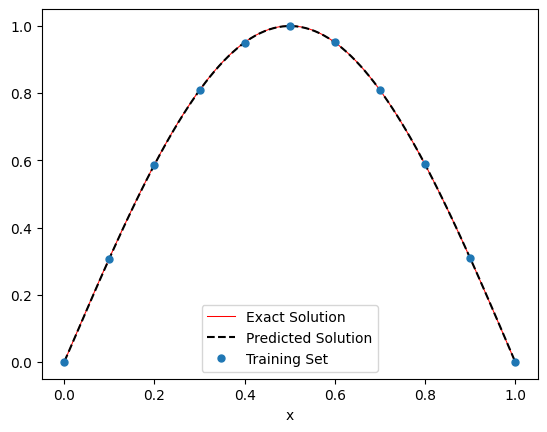

In [218]:
plt.plot(x_test,y_test,label = "Exact Solution",linestyle="-",color = "red",linewidth = 0.75)
plt.plot(x_test,y_pred,label = "Predicted Solution",linestyle="--",linewidth = 1.5,color = "black")
plt.plot(x_train,y_train,label="Training Set",linestyle = "None", marker = "o",markersize  =5)
plt.xlabel("x")
plt.legend()
plt.show()

### Convergence Study

In [219]:
epochs = [1000,2000,4000,8000]
L2_err = []

# generate the training set
n_train = 11
x_train = torch.linspace(0,1,n_train).reshape(-1,1)

# generate the test set
n_test = 100
x_test = torch.linspace(0,1,n_test).reshape(-1,1)
y_test = u_exact(x_test)

for epoch in epochs:
    u = train_PINN(x_train,num_epochs,verbose=False)
    y_pred = u(x_test)

    L2_err.append(L2_error(y_pred,y_test).detach().numpy())

table = pd.DataFrame(data= np.transpose([epochs, L2_err]),columns=["Epochs","L2 error"])
table

,Epochs,L2 error
0,1000.0,7.446153e-06
1,2000.0,2.225827e-06
2,4000.0,2.043080e-06
3,8000.0,3.408079e-07


In [226]:
train_size = [10,20,40,80,160]
L2_err = []

# generate the test set
n_test = 1000
x_test = torch.linspace(0,1,n_test).reshape(-1,1)
y_test = u_exact(x_test)

for n_train in train_size:
    # generate the training set
    x_train = torch.linspace(0,1,n_train).reshape(-1,1)

    u = train_PINN(x_train,num_epochs,verbose=False)
    y_pred = u(x_test)

    L2_err.append(L2_error(y_pred,y_test).detach().numpy())

table = pd.DataFrame(data= np.transpose([train_size, L2_err]),columns=["Train size","L2 error"])
table

,Train size,L2 error
0,10.0,4.474102e-05
1,20.0,1.428327e-05
2,40.0,1.664795e-04
3,80.0,1.217455e-05
4,160.0,9.705282e-07


## Eigenvalue problem

In [129]:
def eigenvalue(m,n):
    return (m**2 + n**2)*pi**2

def eigenfunc(m,n,x):
    return sin(m*pi*x[0])*sin(n*pi*x[1])

In [ ]:
#define PINN neural network using nn.Module class
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 1)
        )

    def forward(self, x):
        return self.net(x)

#neural network functions
def grad(outputs, inputs):
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs),create_graph=True)[0]

In [131]:
def compute_loss(model: nn.Module, x: torch.Tensor, eigenval):
    #evaluating u(x), f(x), du/dx, d^2u/dx^2 at collocation points x
    x.requires_grad_(True)
    u = model(x)
    du = grad(u,x)
    d2u = grad(du,x)

    #ODE residual: -u"(x) - f(x)
    residual = -d2u - eigenval*u
    interior_loss = torch.mean(residual ** 2)

    # calculating boundary loss for problem
    x1_residual = model(torch.tensor([0.0,0.0])) - torch.tensor([0.0])
    x2_residual = model(torch.tensor([0.0,1.0])) - torch.tensor([0.0])
    x3_residual = model(torch.tensor([1.0,0.0])) - torch.tensor([0.0])
    x4_residual = model(torch.tensor([1.0,1.0])) - torch.tensor([0.0])
    boundary_loss = torch.mean(x1_residual ** 2 + x2_residual ** 2 + x3_residual ** 2 + x4_residual ** 2)

    return interior_loss + boundary_loss

In [132]:
def train_PINN(x_train):
    # Training the PINN
    model = PINN()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    # Iterate training over epochs
    for epoch in range(5000):
        loss = compute_loss(model, x_train,eigenvalue(1,1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print(f"Full Training Epoch {epoch}, Loss: {loss.item():.6f}")
    return model

In [133]:
# Helper function to plot results
def create_results(x_train, color='red', label=''):
    model = train_PINN(x_train)
    y_pred = model(x_train).detach().numpy()
    print(y_pred)
    # plt.plot(x_train.detach().numpy(), y_pred, label=label, color=color, linestyle='--')

In [134]:
# #Generating collocation points
# def generate_collocation_points(method='uniform', num_points=10):
#     if method == 'uniform':
#         x_train = np.linspace(-1, 1, num_points)
#     elif method == 'gauss_legendre':
#         x_train = roots_legendre(num_points)[0]
#     else:
#         raise ValueError("Unsupported quadrature method")
#     return torch.tensor(x_train.reshape(-1,1), dtype=torch.float32)

In [137]:
def generate_train(n):
    xx = np.linspace(0,1,n+1,endpoint=False)
    xx = xx[1:]
    yy = np.linspace(0,1,n+1,endpoint=False)
    yy = yy[1:]
    x = []
    for i in range(len(xx)):
        for j in range(len(yy)):
            x.append((xx[i],yy[j]))
    return torch.tensor(x, dtype=torch.float32)

In [138]:
# # Plotting True Result
# x_test = torch.linspace(-1, 1, 100).reshape(-1, 1)
# y_true = torch.tanh(x_test).numpy()
# plt.plot(x_test.numpy(), y_true, label= r'True Solution$', color='green')

# Getting Collocation Points and weights
uniform = generate_train(3)

#Plotting results
create_results(uniform, color='blue',label='Uniform')

# #Plotting Prettiness
# plt.xlabel('x')
# plt.ylabel('u(x)')
# plt.legend()
# title = r"$-u''(x) = Eu(x)$"
# plt.title(title)
# plt.show()

Full Training Epoch 0, Loss: 2.530972
Full Training Epoch 500, Loss: 0.000062
Full Training Epoch 1000, Loss: 0.000015
Full Training Epoch 1500, Loss: 0.000009
Full Training Epoch 2000, Loss: 0.000006
Full Training Epoch 2500, Loss: 0.000005
Full Training Epoch 3000, Loss: 0.000004
Full Training Epoch 3500, Loss: 0.000002
Full Training Epoch 4000, Loss: 0.000002
Full Training Epoch 4500, Loss: 0.000002
[[-4.7217309e-04]
 [-4.8436224e-04]
 [-1.6510487e-04]
 [-4.2732432e-04]
 [-2.5243312e-04]
 [ 7.0832670e-05]
 [-1.6761944e-04]
 [ 6.8768859e-05]
 [ 3.0664727e-04]]


In [139]:
uniform.requires_grad = False
uniform

tensor([[0.2500, 0.2500],
        [0.2500, 0.5000],
        [0.2500, 0.7500],
        [0.5000, 0.2500],
        [0.5000, 0.5000],
        [0.5000, 0.7500],
        [0.7500, 0.2500],
        [0.7500, 0.5000],
        [0.7500, 0.7500]])

In [140]:
uniform = np.array(uniform,dtype=np.float64)
uniform

C:\Users\Shivam\AppData\Local\Temp\ipykernel_21852\3803564809.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  uniform = np.array(uniform,dtype=np.float64)


array([[0.25, 0.25],
       [0.25, 0.5 ],
       [0.25, 0.75],
       [0.5 , 0.25],
       [0.5 , 0.5 ],
       [0.5 , 0.75],
       [0.75, 0.25],
       [0.75, 0.5 ],
       [0.75, 0.75]])

In [141]:
y_test = []
for i in range(len(uniform)):
    y_test.append(eigenfunc(m=1,n=1,x=uniform[i]))
y_test

[np.float64(0.5000000000000001),
 np.float64(0.7071067811865476),
 np.float64(0.5000000000000001),
 np.float64(0.7071067811865476),
 np.float64(1.0),
 np.float64(0.7071067811865476),
 np.float64(0.5000000000000001),
 np.float64(0.7071067811865476),
 np.float64(0.5000000000000001)]